# Final Project Deeplearining AML 3104 S23 Section-2
## Plant disease classification

## Group members:
* Pratik Patel          C0861105
* Drashti Shukla        C0860046
* Resha Soni            C0859047
* Arpit Valand          C0857938

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [2]:
disease_types = ['Pepper__bell___Bacterial_spot',
                 'Pepper__bell___healthy',
                 'Potato___Early_blight',
                 'Potato___Late_blight',
                 'Potato___healthy',
                 'Tomato_Bacterial_spot',
                 'Tomato_Early_blight',
                 'Tomato_Late_blight',
                 'Tomato_Leaf_Mold',
                 'Tomato_Septoria_leaf_spot',
                 'Tomato_Spider_mites_Two_spotted_spider_mite',
                 'Tomato__Target_Spot',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus',
                 'Tomato__Tomato_mosaic_virus',
                 'Tomato_healthy']

data_dir = './PlantVillage/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/ff354b62-5981-43d1-8cfe-ac58bc2...,14,Tomato_healthy
20635,Tomato_healthy/ff774aec-2504-4d11-8a61-2fd74c6...,14,Tomato_healthy
20636,Tomato_healthy/ff8b36d5-feaf-4d2d-8126-18670a3...,14,Tomato_healthy
20637,Tomato_healthy/ffb39943-eabb-42cf-ad09-b17019e...,14,Tomato_healthy
20638,Tomato_healthy/ffd8aa68-138f-4114-96c7-21eef72...,14,Tomato_healthy


In [4]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy
1,Potato___Early_blight/900514b4-8768-4370-bc53-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy
4,Tomato_Leaf_Mold/2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold


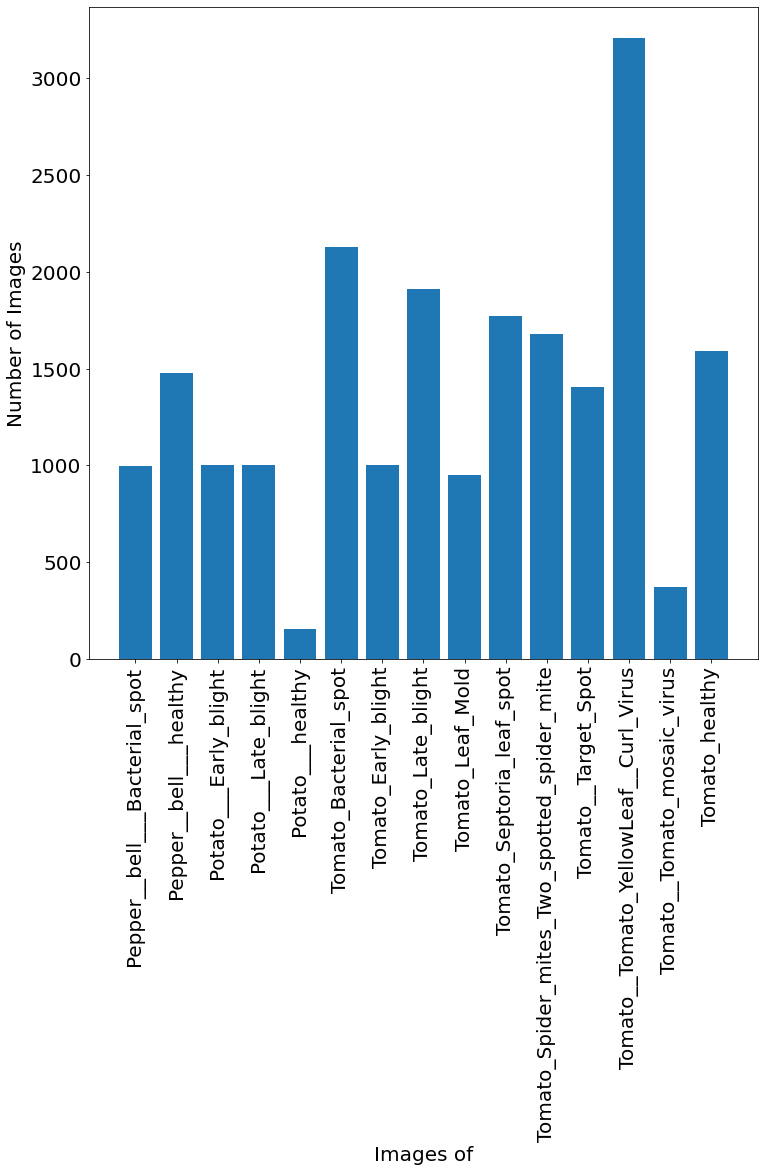

In [13]:
dta = train.DiseaseID.value_counts(sort=False)
dis = train.drop_duplicates(subset='DiseaseID', keep='first')
mapping_dict = dict(zip(dis['DiseaseID'], dis['Disease Type']))

index_values = list(mapping_dict.keys())
x_labels = [mapping_dict[i] for i in index_values]
plt.figure(figsize=(12, 12))
plt.bar(index_values, dta, tick_label=x_labels)
plt.xticks(rotation=90, fontsize=20)  # Adjust the fontsize as needed
plt.yticks(fontsize=20)  # Adjust the fontsize as needed
plt.xlabel('Images of', fontsize=20)  # Adjust the fontsize as needed
plt.ylabel('Number of Images', fontsize=20)  # Adjust the fontsize as needed
plt.show()

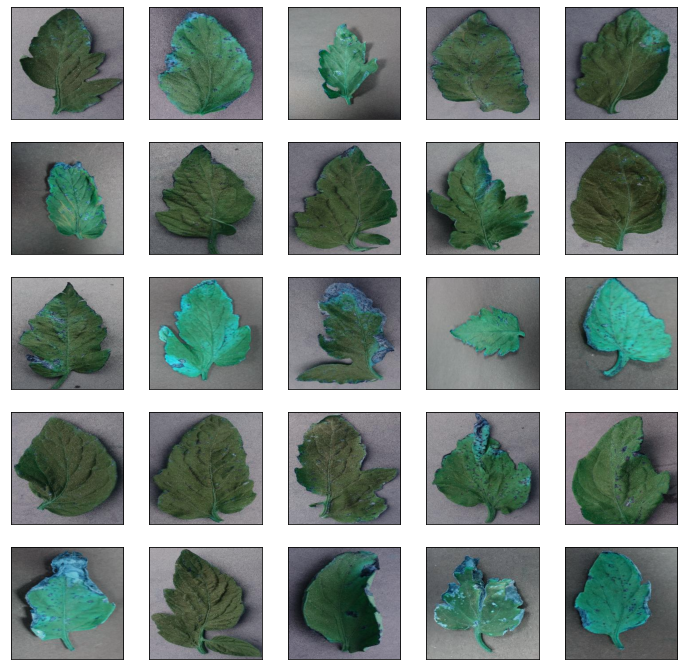

In [6]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [7]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [01:33, 220.42it/s]


Train Shape: (20639, 64, 64, 3)


In [9]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [10]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

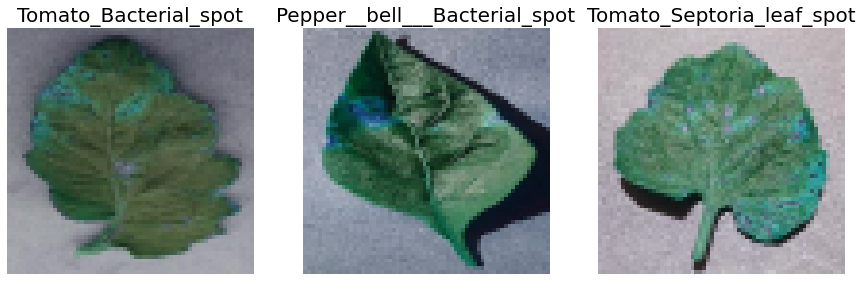

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])], fontsize=20)
plt.show()

In [15]:
EPOCHS = 50
BATCH_SIZE = 64
SIZE=64
N_ch=3

In [16]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [18]:
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))
model.save('final_model.h5')

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.64742, saving model to model.h5
257/257 - 674s - loss: 2.5551 - accuracy: 0.3215 - val_loss: 1.6474 - val_accuracy: 0.4288 - lr: 0.0020 - 674s/epoch - 3s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.64742 to 0.86107, saving model to model.h5
257/257 - 639s - loss: 0.9701 - accuracy: 0.6963 - val_loss: 0.8611 - val_accuracy: 0.7190 - lr: 0.0020 - 639s/epoch - 2s/step
Epoch 3/50

Epoch 3: val_loss improved from 0.86107 to 0.67132, saving model to model.h5
257/257 - 675s - loss: 0.5647 - accuracy: 0.8214 - val_loss: 0.6713 - val_accuracy: 0.8035 - lr: 0.0020 - 675s/epoch - 3s/step
Epoch 4/50

Epoch 4: val_loss improved from 0.67132 to 0.52811, saving model to model.h5
257/257 - 627s - loss: 0.4117 - accuracy: 0.8684 - val_loss: 0.5281 - val_accuracy: 0.8445 - lr: 0.0020 - 627s/epoch - 2s/step
Epoch 5/50

Epoch 5: val_loss improved from 0.52811 to 0.49163, saving model to model.h5
257/257 - 618s - loss: 0.3125 - accuracy: 0.9005 - 

Epoch 43/50

Epoch 43: val_loss did not improve from 0.15281
257/257 - 634s - loss: 0.0354 - accuracy: 0.9889 - val_loss: 0.5959 - val_accuracy: 0.8844 - lr: 0.0010 - 634s/epoch - 2s/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.15281
257/257 - 627s - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.2714 - val_accuracy: 0.9317 - lr: 0.0010 - 627s/epoch - 2s/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.15281
257/257 - 614s - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.4826 - val_accuracy: 0.9048 - lr: 0.0010 - 614s/epoch - 2s/step
Epoch 46/50

Epoch 46: val_loss did not improve from 0.15281
257/257 - 628s - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.7181 - val_accuracy: 0.8498 - lr: 0.0010 - 628s/epoch - 2s/step
Epoch 47/50

Epoch 47: val_loss did not improve from 0.15281
257/257 - 635s - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.1684 - val_accuracy: 0.9557 - lr: 0.0010 - 635s/epoch - 2s/step
Epoch 48/50

Epoch 48: val_loss improved from 0.15281 to 0.1

In [19]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 [==============================] - 42s 321ms/step - loss: 0.4695 - accuracy: 0.8941
Final Loss: 0.46950942277908325, Final Accuracy: 0.8941376209259033


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

classification_rep = classification_report(Y_true, Y_pred)
print("Classification Report:\n", classification_rep)

129/129 [==============================] - 47s 313ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.99      0.86      0.92       296
           2       0.98      1.00      0.99       213
           3       0.83      0.99      0.90       205
           4       0.41      1.00      0.58        28
           5       0.99      0.74      0.85       399
           6       0.74      0.90      0.82       206
           7       1.00      0.83      0.90       379
           8       1.00      0.71      0.83       187
           9       0.91      0.97      0.94       359
          10       0.95      0.64      0.77       326
          11       0.60      0.99      0.74       290
          12       1.00      0.98      0.99       629
          13       0.87      0.98      0.92        81
          14       0.91      1.00      0.95       331

    accuracy                           0.89      412

Text(0.5, 144.41374999999996, 'Predicted')

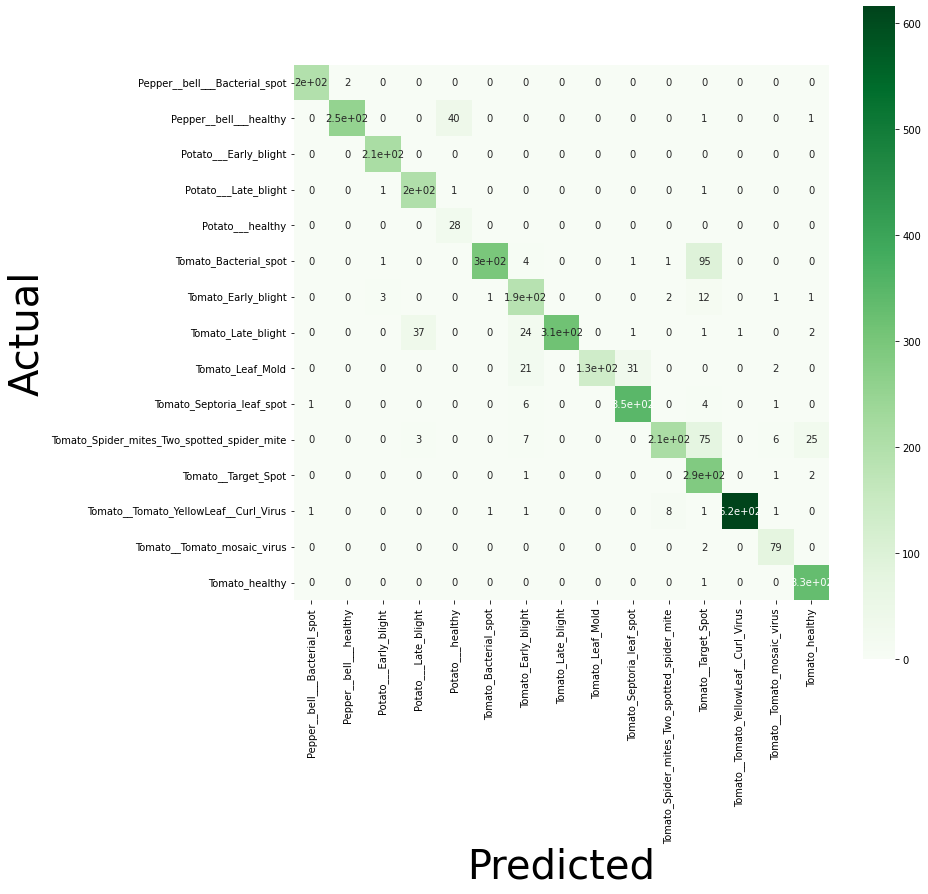

In [21]:
# Y_pred = model.predict(X_val)

# Y_pred = np.argmax(Y_pred, axis=1)
# Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

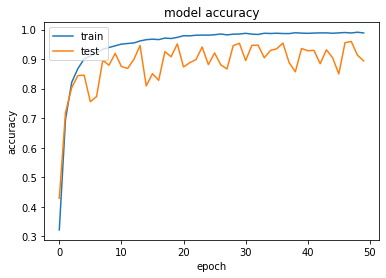

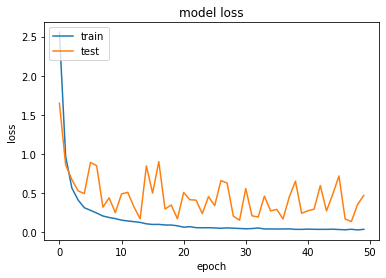

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Disease Prediction

1/1 [==============================] - 6s 6s/step
[1.2616019e-06 2.1689330e-04 9.9775153e-01 4.5890392e-06 6.8393798e-04
 3.6215940e-08 8.0321688e-06 4.4678131e-06 1.0409150e-05 1.2719572e-03
 9.9590750e-08 8.5819727e-07 3.9545598e-09 1.1814846e-05 3.4065026e-05]


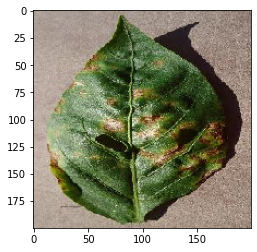

Prediction: Potato___Early_blight


In [31]:
# from skimage import io
# from keras.preprocessing import image
import keras.utils as image
#path='imbalanced/Scratch/Scratch_400.jpg'
# "C:\Users\prati\Desktop\AML 3104 final project\PlantVillage\Pepper__bell___Bacterial_spot\00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG"
pth = r"C:\Users\prati\Desktop\AML 3104 final project\PlantVillage\Pepper__bell___Bacterial_spot\0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG"
img = image.load_img(pth, grayscale=False, target_size=(64, 64))
show_img=image.load_img(pth, grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot',
                 'Pepper__bell___healthy',
                 'Potato___Early_blight',
                 'Potato___Late_blight',
                 'Potato___healthy',
                 'Tomato_Bacterial_spot',
                 'Tomato_Early_blight',
                 'Tomato_Late_blight',
                 'Tomato_Leaf_Mold',
                 'Tomato_Septoria_leaf_spot',
                 'Tomato_Spider_mites_Two_spotted_spider_mite',
                 'Tomato__Target_Spot',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus',
                 'Tomato__Tomato_mosaic_virus',
                 'Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = np.array(x, 'float32')
x /= 255
model = load_model('./final_model.h5')
custom = model.predict(x)
print(custom[0])

#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])